In [4]:
import numpy as np
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, MaxPool2D, Conv2D, Flatten, Dropout, BatchNormalization
from keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import collections
import csv
import numpy
import pandas as pd
import efficientnet.keras as efn
from collections import Counter
from keras.applications.vgg16 import VGG16
warnings.simplefilter(action='ignore', category = FutureWarning)
%matplotlib inline

In [2]:
train_path= 'train'
valid_path = 'valid'
test_path = 'test'

In [5]:
train_batches = ImageDataGenerator(rescale = 1.0/255.,zoom_range=0.2).flow_from_directory(directory=train_path, target_size=(224,224), classes=['health','one','two','unused'],batch_size=10)
test_batches = ImageDataGenerator(rescale = 1.0/255.).flow_from_directory(directory=test_path, target_size=(224,224), classes=['health','one','two','unused'],batch_size=10,shuffle=False)
valid_batches = ImageDataGenerator(rescale = 1.0/255.).flow_from_directory(directory=valid_path, target_size=(224,224), classes=['health','one','two','unused'],batch_size=10)


Found 4508 images belonging to 4 classes.
Found 833 images belonging to 4 classes.
Found 892 images belonging to 4 classes.


In [6]:
imgs, labels = next(train_batches)

In [7]:
#plot images 
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr , axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

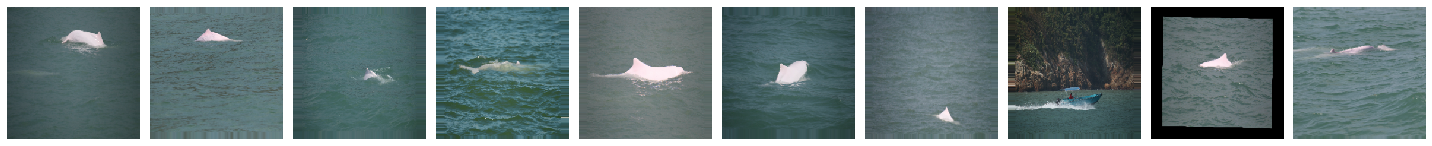

[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


In [8]:
plotImages(imgs)
print(labels)

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# EfficientNetB0

In [18]:
base_model = efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable=False
x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(500, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(300, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(4, activation='softmax')(x)
Efficient_model = keras.models.Model(inputs=base_model.input, outputs=predictions)

# adding regularization
#regularizer = tf.keras.regularizers.l2(penalty)
regularizer = tf.keras.regularizers.l2(0.1)

for layer in Efficient_model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)
        
Efficient_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_9[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
_______________________________________________________________________________________

In [19]:
counter = Counter(train_batches.classes)
max_val = float(max(counter.values()))
class_weights={class_id : max_val/num_images for class_id, num_images in counter.items()}
Efficient_model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
history_1=Efficient_model.fit(x=train_batches,validation_data=valid_batches, class_weight=class_weights,epochs=20,verbose=2)

Epoch 1/20
451/451 - 1118s - loss: 2.6896 - accuracy: 0.4971 - val_loss: 1.0360 - val_accuracy: 0.6435
Epoch 2/20
451/451 - 1104s - loss: 1.9915 - accuracy: 0.6145 - val_loss: 0.9048 - val_accuracy: 0.7052
Epoch 3/20
451/451 - 1097s - loss: 1.7596 - accuracy: 0.6517 - val_loss: 0.9292 - val_accuracy: 0.6670
Epoch 4/20
451/451 - 1101s - loss: 1.7165 - accuracy: 0.6566 - val_loss: 1.0051 - val_accuracy: 0.6570
Epoch 5/20
451/451 - 1101s - loss: 1.5683 - accuracy: 0.6857 - val_loss: 0.9269 - val_accuracy: 0.6771
Epoch 6/20
451/451 - 1100s - loss: 1.4901 - accuracy: 0.6925 - val_loss: 1.0917 - val_accuracy: 0.6558
Epoch 7/20
451/451 - 1099s - loss: 1.4204 - accuracy: 0.7083 - val_loss: 0.9223 - val_accuracy: 0.6962
Epoch 8/20
451/451 - 1094s - loss: 1.3790 - accuracy: 0.7130 - val_loss: 1.0259 - val_accuracy: 0.6682
Epoch 9/20
451/451 - 1105s - loss: 1.3465 - accuracy: 0.7150 - val_loss: 1.0596 - val_accuracy: 0.6581
Epoch 10/20
451/451 - 1109s - loss: 1.2120 - accuracy: 0.7518 - val_loss:

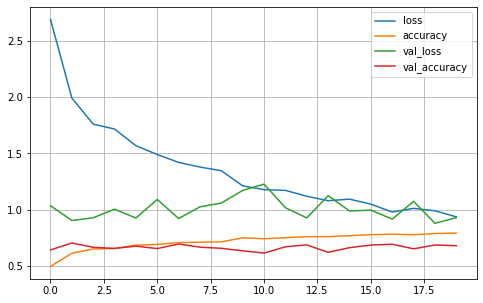

In [20]:
pd.DataFrame(history_1.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

Confusion matrix, without normalization
[[486   9  81   7]
 [  2  11  18   0]
 [ 39  15 119   0]
 [  0   0   0  46]]


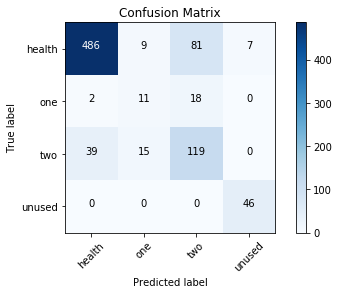

In [21]:
predictions = Efficient_model.predict(x=test_batches, verbose=0)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot=['health','one','two','unused']
plot_confusion_matrix(cm=cm, classes=cm_plot, title='Confusion Matrix')

In [22]:
print('0: Health , 1: One , 2: Two , 3: Unused')
predictions = Efficient_model.predict(x=test_batches, verbose=0)
ytest= test_batches.classes
ypredict = np.argmax(predictions,axis=-1)
print(classification_report(ytest,ypredict))

0: Health , 1: One , 2: Two , 3: Unused
              precision    recall  f1-score   support

           0       0.92      0.83      0.88       583
           1       0.31      0.35      0.33        31
           2       0.55      0.69      0.61       173
           3       0.87      1.00      0.93        46

    accuracy                           0.79       833
   macro avg       0.66      0.72      0.69       833
weighted avg       0.82      0.79      0.80       833



In [23]:
Efficient_model.save('efficientnetb0_one_unused_augmented_regularisation.h5')

In [ ]:
list_predictions=list(np.argmax(predictions, axis=-1))
list_filename = test_batches.filenames
final_predictions=[]
for item in zip(list_filename,list_predictions):
    final_predictions.append(item)

#predictions and labels 
arr = numpy.array(final_predictions)

# convert array into dataframe 
DF = pd.DataFrame(arr) 
  
# save the dataframe as a csv file 
DF.to_csv("efficientnet.csv")

# finetuning

In [24]:
base_modelll_model_model_model.trainable= True
set_trainable = False
for layer in base_model.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [25]:
Efficient_model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
history_2=Efficient_model.fit(x=train_batches,validation_data=valid_batches, class_weight=class_weights,epochs=20,verbose=2)

Epoch 1/20
451/451 - 1207s - loss: 0.9130 - accuracy: 0.8103 - val_loss: 0.9195 - val_accuracy: 0.6984
Epoch 2/20
451/451 - 1200s - loss: 0.8778 - accuracy: 0.8106 - val_loss: 0.9053 - val_accuracy: 0.6827
Epoch 3/20
451/451 - 1201s - loss: 0.8643 - accuracy: 0.8103 - val_loss: 0.9642 - val_accuracy: 0.6626
Epoch 4/20
451/451 - 1199s - loss: 0.8724 - accuracy: 0.8081 - val_loss: 0.8940 - val_accuracy: 0.6704
Epoch 5/20
451/451 - 1200s - loss: 0.8643 - accuracy: 0.8050 - val_loss: 1.0404 - val_accuracy: 0.6435
Epoch 6/20
451/451 - 1201s - loss: 0.8274 - accuracy: 0.8139 - val_loss: 0.8822 - val_accuracy: 0.6749
Epoch 7/20
451/451 - 1200s - loss: 0.8315 - accuracy: 0.8137 - val_loss: 0.9378 - val_accuracy: 0.6693
Epoch 8/20
451/451 - 1198s - loss: 0.8040 - accuracy: 0.8301 - val_loss: 0.8850 - val_accuracy: 0.6783
Epoch 9/20
451/451 - 1200s - loss: 0.7970 - accuracy: 0.8290 - val_loss: 0.9227 - val_accuracy: 0.6760
Epoch 10/20
451/451 - 1201s - loss: 0.7976 - accuracy: 0.8150 - val_loss:

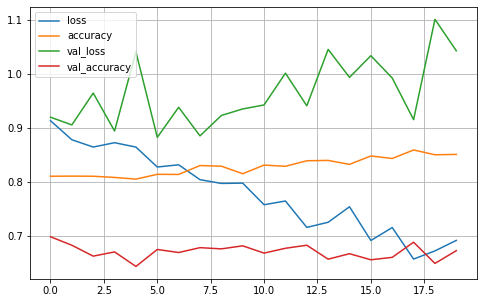

In [26]:
pd.DataFrame(history_2.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

Confusion matrix, without normalization
[[478  16  84   5]
 [  2  15  14   0]
 [ 38  27 108   0]
 [  0   0   0  46]]


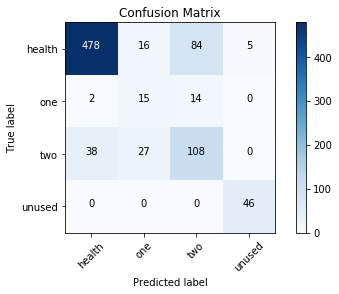

In [27]:
predictions = Efficient_model.predict(x=test_batches, verbose=0)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot=['health','one','two','unused']
plot_confusion_matrix(cm=cm, classes=cm_plot, title='Confusion Matrix')

In [28]:
print('0: Health , 1: One , 2: Two , 3: Unused')
predictions = Efficient_model.predict(x=test_batches, verbose=0)
ytest= test_batches.classes
ypredict = np.argmax(predictions,axis=-1)
print(classification_report(ytest,ypredict))

0: Health , 1: One , 2: Two , 3: Unused
              precision    recall  f1-score   support

           0       0.92      0.82      0.87       583
           1       0.26      0.48      0.34        31
           2       0.52      0.62      0.57       173
           3       0.90      1.00      0.95        46

    accuracy                           0.78       833
   macro avg       0.65      0.73      0.68       833
weighted avg       0.81      0.78      0.79       833



In [29]:
Efficient_model.save('efficientnetb0_finetuned_one_unused_augmented_regularisation.h5')

In [30]:
list_predictions=list(np.argmax(predictions, axis=-1))
list_filename = test_batches.filenames
final_predictions=[]
for item in zip(list_filename,list_predictions):
    final_predictions.append(item)

#predictions and labels 
arr = numpy.array(final_predictions)

# convert array into dataframe 
DF = pd.DataFrame(arr) 
  
# save the dataframe as a csv file 
DF.to_csv("efficientnet_finetune.csv")